Libraries needed for training and testing

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -r /content/drive/MyDrive/notebook_data/requirements.txt

# Setup

### Imports

In [3]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
from typing import Tuple, List
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

### Configuration

In [4]:
# Configuration variables
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_FILENAME = "model.pkl"
SCALER_FILENAME = "scaler.pkl"
ENSEMBLE_MODEL_FILENAME = "ensemble_model.pkl"
ENSEMBLE_SCALER_FILENAME = "ensemble_scaler.pkl"

# Data Augmentation Configuration
AUGMENTATION_CONFIG = {
    'num_augmentations': 2,
    'time_stretch_range': (0.995, 1.005),  # Very minimal
    'pitch_shift_range': (-1, 1),
    'noise_level_range': (0.0000001, 0.000001),  # Extremely low noise
    'time_shift_range': (-20, 20),  # Very small shift
    'amplitude_scale_range': (0.995, 1.005)  # Very minimal
}

# Data Augmentation

In [5]:
def validate_augmented_features(features: np.ndarray, original_features: np.ndarray) -> bool:
    """Validate that augmented features are within reasonable bounds."""
    if features is None or original_features is None:
        print("Validation failed: Features are None")
        return False

    # Ensure both arrays are numpy arrays
    features = np.array(features)
    original_features = np.array(original_features)

    # Normalize both feature arrays
    features_norm = (features - np.mean(features)) / (np.std(features) + 1e-10)
    original_norm = (original_features - np.mean(original_features)) / (np.std(original_features) + 1e-10)

    # Calculate correlation between normalized features
    feature_correlation = np.corrcoef(features_norm, original_norm)[0, 1]

    # Calculate relative difference in means
    mean_diff = np.abs(np.mean(features) - np.mean(original_features)) / (np.mean(original_features) + 1e-10)

    # Calculate relative difference in standard deviations
    std_diff = np.abs(np.std(features) - np.std(original_features)) / (np.std(original_features) + 1e-10)

    # Print validation metrics for debugging
    print(f"Validation metrics:")
    print(f"Correlation: {feature_correlation:.4f}")
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"Std difference: {std_diff:.4f}")

    # More lenient validation criteria
    if feature_correlation < 0.2:  # Very lenient correlation threshold
        print(f"Validation failed: Correlation {feature_correlation:.4f} below threshold 0.2")
        return False

    if mean_diff > 2.0:  # Allow up to 200% difference in means
        print(f"Validation failed: Mean difference {mean_diff:.4f} exceeds threshold 2.0")
        return False

    if std_diff > 2.0:  # Allow up to 200% difference in standard deviations
        print(f"Validation failed: Std difference {std_diff:.4f} exceeds threshold 2.0")
        return False

    return True

In [6]:
def augment_audio(audio_path: str, output_dir: str, num_augmentations: int) -> List[str]:
    """Apply validated audio augmentation techniques efficiently."""
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Load and extract original features once
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        original_features = extract_high_advanced_features(audio_path)

        if original_features is None:
            print(f"Warning: Could not extract features from {audio_path}")
            return []

        augmented_files = []
        base_name = os.path.splitext(os.path.basename(audio_path))[0]

        # Pre-compute all augmentation parameters
        augmentation_params = []
        for i in range(num_augmentations):
            params = {
                'pitch_shift': random.randint(-1, 1),
                'time_stretch': random.uniform(0.995, 1.005),
                'noise_level': random.uniform(0.0000001, 0.000001),
                'time_shift': random.randint(-20, 20),
                'scale_factor': random.uniform(0.995, 1.005)
            }
            augmentation_params.append(params)

        # Process all augmentations in a single loop
        for i, params in enumerate(augmentation_params):
            aug_y = y.copy()

            # Apply augmentations in a specific order for efficiency
            if random.random() < 0.5:
                aug_y = librosa.effects.time_stretch(aug_y, rate=params['time_stretch'])

            if random.random() < 0.5:
                aug_y = librosa.effects.pitch_shift(aug_y, sr=sr, n_steps=params['pitch_shift'])

            if random.random() < 0.3:
                noise = np.random.normal(0, params['noise_level'], len(aug_y))
                aug_y = aug_y + noise

            if random.random() < 0.3:
                aug_y = np.roll(aug_y, params['time_shift'])

            if random.random() < 0.5:
                aug_y = aug_y * params['scale_factor']

            # Save augmented audio
            output_path = os.path.join(output_dir, f"{base_name}_aug_{i}.wav")
            sf.write(output_path, aug_y, sr)

            # Validate features
            augmented_features = extract_high_advanced_features(output_path)
            if augmented_features is not None and validate_augmented_features(augmented_features, original_features):
                augmented_files.append(output_path)
                print(f"Successfully validated augmentation {i} for {base_name}")
            else:
                os.remove(output_path)
                print(f"Warning: Augmented file {output_path} failed validation")

        return augmented_files

    except Exception as e:
        print(f"Error in augment_audio for {audio_path}: {str(e)}")
        return []

In [7]:
def augment_dataset(real_dir: str, fake_dir: str, output_real_dir: str, output_fake_dir: str) -> Tuple[int, int]:
    """Efficiently augment the dataset with parallel processing."""
    # Create output directories
    augmented_real_dir = output_real_dir
    augmented_fake_dir = output_fake_dir
    os.makedirs(augmented_real_dir, exist_ok=True)
    os.makedirs(augmented_fake_dir, exist_ok=True)

    # Get list of audio files
    real_files = [f for f in os.listdir(real_dir) if f.endswith('.wav')]
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.wav')]

    # Calculate augmentation ratios
    real_ratio = max(1, len(fake_files) // len(real_files))
    fake_ratio = max(1, len(real_files) // len(fake_files))

    print(f"\nAugmentation ratios:")
    print(f"Real files: {len(real_files)} -> {real_ratio} augmentations")
    print(f"Fake files: {len(fake_files)} -> {fake_ratio} augmentations")

    # Process real files
    print("\nAugmenting real files...")
    real_augmented_count = 0
    for audio_file in real_files:
        print(f"\nProcessing {audio_file}...")
        audio_path = os.path.join(real_dir, audio_file)
        augmented_files = augment_audio(audio_path, augmented_real_dir, real_ratio)
        real_augmented_count += len(augmented_files)
        print(f"Processed {audio_file}: {len(augmented_files)} successful augmentations")

    # Process fake files
    print("\nAugmenting fake files...")
    fake_augmented_count = 0
    for audio_file in fake_files:
        print(f"\nProcessing {audio_file}...")
        audio_path = os.path.join(fake_dir, audio_file)
        augmented_files = augment_audio(audio_path, augmented_fake_dir, fake_ratio)
        fake_augmented_count += len(augmented_files)
        print(f"Processed {audio_file}: {len(augmented_files)} successful augmentations")

    return real_augmented_count, fake_augmented_count

# Dataprep & Feature Extraction

In [8]:
def extract_high_advanced_features(audio_path: str, sr: int = SAMPLE_RATE, n_mfcc: int = N_MFCC,
                           n_fft: int = N_FFT, hop_length: int = HOP_LENGTH) -> np.ndarray:
    """
    Extract a comprehensive set of audio features beyond basic MFCCs.

    Args:
        audio_path: Path to audio file
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        n_fft: FFT window size
        hop_length: Hop length for feature extraction

    Returns:
        Feature vector combining spectral, temporal, and perceptual features
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)

        # ===== Spectral Features =====

        # 1. MFCCs (mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)

        # 2. Spectral centroid (center of mass of the spectrum)
        cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        cent_mean = np.mean(cent)
        cent_var = np.var(cent)

        # 3. Spectral bandwidth (variance around the centroid)
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_var = np.var(bandwidth)

        # 4. Spectral contrast (valley/peak contrast in each frequency subband)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        contrast_mean = np.mean(contrast, axis=1)

        # 5. Spectral rolloff (frequency below which a percentage of spectral energy lies)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)

        # 6. Chroma features (pitch class profiles)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        chroma_mean = np.mean(chroma, axis=1)

        # ===== Temporal Features =====

        # 7. Zero crossing rate (sign changes along a signal)
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
        zcr_mean = np.mean(zcr)
        zcr_var = np.var(zcr)

        # 8. Tempo estimation (beat tracking)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

        # ===== Voice-specific Features =====

        # 9. Harmonic components
        y_harmonic, y_percussive = librosa.effects.hpss(y)

        # 10. RMS energy (root-mean-square energy)
        rms = librosa.feature.rms(y=y, hop_length=hop_length)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)

        # 11. Spectral flatness (how noise-like a sound is)
        flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length)
        flatness_mean = np.mean(flatness)
        flatness_var = np.var(flatness)

        # ===== Voice Formant Features =====

        # 12. Apply a simple approximation of formant frequencies
        # This uses the first few MFCCs which roughly correspond to vocal tract shape
        formant_approximation = mfcc_means[1:5]  # MFCCs 1-4 roughly correspond to formants

        # ===== Statistical Features =====

        # 13. Pitch statistics based on CREPE if needed (using simpler approach here)
        # Extract pitch using auto-correlation method
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        pitch_max = np.mean(np.max(pitches, axis=0))
        pitch_var = np.var(np.max(pitches, axis=0))

        # 14. Voice jitter approximation (variation in pitch periodicity)
        # This is a simplified approach - professional voice analysis uses dedicated algorithms
        if len(y) > sr // 1000:  # Only if we have enough samples
            y_trimmed = y[:sr//2]  # Use first half-second for efficiency
            zero_crossings = librosa.zero_crossings(y_trimmed)
            zero_crossing_indices = np.where(zero_crossings)[0]
            if len(zero_crossing_indices) > 2:
                # Calculate intervals between consecutive zero crossings
                intervals = np.diff(zero_crossing_indices)
                jitter_approx = np.var(intervals) / (np.mean(intervals) + 1e-5)
            else:
                jitter_approx = 0
        else:
            jitter_approx = 0

        # Fixed: Make sure all arrays have the same dimensions (1D)
        # Reshape any 2D arrays to 1D before concatenation
        feature_vector = np.concatenate([
          mfcc_means.reshape(-1, 1),             # Convert to 2D (N, 1)
          mfcc_vars.reshape(-1, 1),              # Convert to 2D
          np.array([cent_mean, cent_var]).reshape(-1, 1),
          np.array([bandwidth_mean, bandwidth_var]).reshape(-1, 1),
          contrast_mean.reshape(-1, 1),          # Convert to 2D
          np.array([rolloff_mean, rolloff_var]).reshape(-1, 1),
          chroma_mean.reshape(-1, 1),            # Convert to 2D
          np.array([zcr_mean, zcr_var]).reshape(-1, 1),
          np.array([tempo]).reshape(-1, 1),      # Convert to 2D
          np.array([rms_mean, rms_var]).reshape(-1, 1),
          np.array([flatness_mean, flatness_var]).reshape(-1, 1),
          formant_approximation.reshape(-1, 1),  # Convert to 2D
          np.array([pitch_max, pitch_var]).reshape(-1, 1),
          np.array([jitter_approx]).reshape(-1, 1)
        ], axis=0)  # Stack them vertically




        return feature_vector

    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        import traceback
        traceback.print_exc()
        return None

#### ----------------------------------

In [9]:
def create_dataset(directory: str, label: int) -> tuple[np.ndarray, np.ndarray]:
    if not os.path.isdir(directory):
        print(f"Directory {directory} does not exist")
        return np.array([]), np.array([])

    X, y = [], []
    audio_files = glob.glob(os.path.join(directory, "*.wav"))

    for audio_path in audio_files:
        features = extract_high_advanced_features(audio_path)
        if features is not None:
            X.append(features)
            y.append(label)
        else:
            print(f"Skipped {os.path.basename(audio_path)}")

    print(f"Found {len(X)} samples in {directory}")
    return np.array(X), np.array(y)

# Training

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers import Input, Layer, Attention, LSTM, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

#### Create a Model

#### TRANSFORMERS TESTING -------

In [11]:
def create_transformer_model(input_shape):
    """Create a transformer-based model for audio classification."""
    # Input layer
    inputs = Input(shape=input_shape)

    # Initial feature extraction
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)

    # Reshape for transformer
    x = Reshape((-1, 256))(x)

    # Transformer encoder blocks
    for _ in range(4):  # Number of transformer blocks
        # Multi-head attention
        attention_output = MultiHeadAttention(
            num_heads=8,
            key_dim=32
        )(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Feed-forward network
        ffn = Dense(512, activation='relu')(x)
        ffn = Dense(256)(ffn)
        x = LayerNormalization(epsilon=1e-6)(x + ffn)
        x = Dropout(0.1)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC()]
    )

    return model

##### Train transformers

In [12]:
def train_transformer_model(X_train, y_train, X_val, y_val):
    """Train the transformer model with enhanced techniques."""
    # Create and compile the model
    model = create_transformer_model(input_shape=(X_train.shape[1], 1))

    # Early stopping with patience
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    # Class weights to handle imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Add model checkpointing
    checkpoint = ModelCheckpoint(
        'best_transformer_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    # Train the model
    history = model.fit(
        X_train.reshape(X_train.shape[0], X_train.shape[1], 1),
        y_train,
        validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

#### ensemble methods training TRIAL ---------------------------------

In [13]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
# Constants
TEST_SIZE = 0.2
RANDOM_STATE = 42

def train_ensemble_model(X_train, y_train, X_val, y_val):
    """Train an ensemble of models with improved voting system."""
    # Split data into training and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create and train multiple models
    models = []
    histories = []

    for i in range(3):  # Train 3 different models
        print(f"\nTraining model {i+1}...")
        # model, history = train_model(X_train, y_train, X_val, y_val)
        model, history = train_transformer_model(X_train, y_train, X_val, y_val)
        models.append(model)
        histories.append(history)

    # Evaluate individual models
    print("\nEvaluating individual models...")
    for i, model in enumerate(models):
        val_loss, val_acc, val_auc = model.evaluate(
            X_val.reshape(X_val.shape[0], X_val.shape[1], 1),
            y_val,
            verbose=0
        )
        print(f"Model {i+1} - Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

    # Select best models based on validation performance
    best_models = []
    for i, model in enumerate(models):
        val_loss, val_acc, val_auc = model.evaluate(
            X_val.reshape(X_val.shape[0], X_val.shape[1], 1),
            y_val,
            verbose=0
        )
        if val_acc > 0.6:  # Only select models with good validation performance
            best_models.append(model)

    if not best_models:
        print("Warning: No models met the performance threshold")
        return None, None

    # Create ensemble predictions with weighted voting
    def ensemble_predict(X):
        predictions = []
        weights = []

        for model in best_models:
            pred = model.predict(X.reshape(X.shape[0], X.shape[1], 1))
            predictions.append(pred)

            # Calculate model weight based on validation performance
            val_loss, val_acc, val_auc = model.evaluate(
                X_val.reshape(X_val.shape[0], X_val.shape[1], 1),
                y_val,
                verbose=0
            )
            weights.append(val_acc)

        # Normalize weights
        weights = np.array(weights) / sum(weights)

        # Weighted voting
        ensemble_pred = np.zeros_like(predictions[0])
        for pred, weight in zip(predictions, weights):
            ensemble_pred += pred * weight

        return ensemble_pred

    # Evaluate ensemble
    print("\nEvaluating ensemble model...")
    ensemble_pred = ensemble_predict(X_test)
    ensemble_pred_binary = (ensemble_pred > 0.5).astype(int)

    print("\nEnsemble Model Test Results:")
    print(classification_report(y_test, ensemble_pred_binary))

    return ensemble_predict, best_models

### Execution

In [15]:
# setup with data augmentation
def run_setup():
    """Main execution flow with data augmentation and detailed data analysis."""
    # Define directories
    real_dir = "/content/drive/MyDrive/notebook_data/real"
    fake_dir = "/content/drive/MyDrive/notebook_data/fake"
    output_real_dir = "/content/drive/MyDrive/notebook_data/augmented_real"
    output_fake_dir = "/content/drive/MyDrive/notebook_data/augmented_fake"

    print("Starting dataset preparation...")

    # First, augment the dataset
    print("\nAugmenting dataset...")
    augmented_real_files, augmented_fake_files = augment_dataset(
        real_dir, fake_dir, output_real_dir, output_fake_dir
    )

    # Print dataset statistics
    print("\nDataset Statistics:")
    print(f"Original real files: {len([f for f in os.listdir(real_dir) if f.endswith('.wav')])}")
    print(f"Original fake files: {len([f for f in os.listdir(fake_dir) if f.endswith('.wav')])}")
    print(f"Real files augmented: {augmented_real_files}")
    print(f"Fake files augmented: {augmented_fake_files}")

    # Load datasets (including augmented files)
    print("\nExtracting features from real audio files...")
    X_real, y_real = create_dataset(output_real_dir, 0)
    print(f"Real features shape: {X_real.shape}")

    print("\nExtracting features from fake audio files...")
    X_fake, y_fake = create_dataset(output_fake_dir, 1)
    print(f"Fake features shape: {X_fake.shape}")

    # Combine datasets
    X = np.vstack([X_real, X_fake]) if X_real.size and X_fake.size else np.concatenate([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])

    if X.size == 0:
        raise ValueError("No valid training data found")

    # Ensure X is a 2D array
    X = np.array(X)
    if X.ndim == 3:
        X = X.squeeze(axis=2)

    # Print final dataset information
    print("\nFinal Dataset Information:")
    print(f"Total samples: {len(y)}")
    print(f"Feature shape: {X.shape}")
    print(f"Class distribution:")
    print(f"- Real samples: {np.sum(y == 0)}")
    print(f"- Fake samples: {np.sum(y == 1)}")

    # Basic feature statistics
    print("\nFeature Statistics:")
    print(f"Mean: {np.mean(X):.4f}")
    print(f"Std: {np.std(X):.4f}")
    print(f"Min: {np.min(X):.4f}")
    print(f"Max: {np.max(X):.4f}")

    # Check for potential issues
    if np.any(np.isnan(X)):
        print("\nWarning: NaN values found in features!")
    if np.any(np.isinf(X)):
        print("Warning: Infinite values found in features!")

    # Verify class balance
    class_ratio = np.sum(y == 0) / np.sum(y == 1)
    if class_ratio < 0.5 or class_ratio > 2.0:
        print("\nWarning: Significant class imbalance detected!")
        print(f"Class ratio (real/fake): {class_ratio:.2f}")

    return X, y

#### **** Split the following cells into 3 sections: SETUP, TRAIN, TEST ****

In [16]:
print("Starting model training pipeline...")
print("Starting dataset preparation...")

# Run setup and get data
X, y = run_setup()

Starting model training pipeline...
Starting dataset preparation...
Starting dataset preparation...

Augmenting dataset...

Augmentation ratios:
Real files: 55 -> 1 augmentations
Fake files: 25 -> 2 augmentations

Augmenting real files...

Processing Playful_and_Energetic.wav...


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Validation metrics:
Correlation: nan
Mean difference: 0.1107
Std difference: 0.1481
Successfully validated augmentation 0 for Playful_and_Energetic
Processed Playful_and_Energetic.wav: 1 successful augmentations

Processing Formal_and_Informative.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0507
Std difference: 0.0626
Successfully validated augmentation 0 for Formal_and_Informative
Processed Formal_and_Informative.wav: 1 successful augmentations

Processing Conversational_and_casual.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0311
Std difference: 0.0258
Successfully validated augmentation 0 for Conversational_and_casual
Processed Conversational_and_casual.wav: 1 successful augmentations

Processing Expressive_and_Emotional.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0080
Std difference: 0.0171
Successfully validated augmentation 0 for Expressive_and_Emotional
Processed Expressive_and_Emotional.wav: 1 successful augmentations

Proc

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Validation metrics:
Correlation: nan
Mean difference: 0.1590
Std difference: 0.1748
Successfully validated augmentation 0 for 3
Processed 3.wav: 1 successful augmentations

Processing 2.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0759
Std difference: 0.0686
Successfully validated augmentation 0 for 2
Processed 2.wav: 1 successful augmentations

Processing 1.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0723
Std difference: 0.0764
Successfully validated augmentation 0 for 1
Processed 1.wav: 1 successful augmentations

Processing Script5.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.0076
Std difference: 0.0140
Successfully validated augmentation 0 for Script5
Processed Script5.wav: 1 successful augmentations

Processing Script4.wav...
Validation metrics:
Correlation: nan
Mean difference: 0.1799
Std difference: 0.1654
Successfully validated augmentation 0 for Script4
Processed Script4.wav: 1 successful augmentations

Processing Script3.

### Train the Model

In [17]:
# Multi-training configuration
NUM_TRAINING_ITERATIONS = 2  # Number of times to train the model
BEST_MODEL_DIR = "best_models"
BEST_TRANSFORMER_PATH = os.path.join(BEST_MODEL_DIR, "best_transformer.keras")  # Added .keras extension
BEST_ENSEMBLE_PATH = os.path.join(BEST_MODEL_DIR, "best_ensemble.keras")  # Added .keras extension

In [18]:
def load_best_models():
    """Load the best saved models."""
    try:
        best_base = tf.keras.models.load_model(BEST_TRANSFORMER_PATH)
        best_ensemble = tf.keras.models.load_model(BEST_ENSEMBLE_PATH)
        return best_base, best_ensemble
    except Exception as e:
        print(f"Error loading best models: {str(e)}")
        return None, None

In [19]:
def train_multiple_models(X_train, y_train, X_val, y_val, num_iterations=NUM_TRAINING_ITERATIONS):
    """Train multiple instances of both base and ensemble models and track the best ones."""
    # Initialize lists to store all trained models
    all_base_models = []
    all_ensemble_models = []
    all_ensemble_predictors = []

    # Initialize best models tracking
    best_base_model = None
    best_base_accuracy = 0.0
    best_ensemble_model = None
    best_ensemble_accuracy = 0.0

    # Create directory for best models if it doesn't exist
    os.makedirs(BEST_MODEL_DIR, exist_ok=True)

    for i in range(num_iterations):
        print("-"*80)
        print("-"*80)
        print(f"\nTraining iteration {i+1}/{num_iterations}")

        # Train base model
        print("\nTraining base model...")
        base_model, base_history = train_transformer_model(X_train, y_train, X_val, y_val)
        all_base_models.append(base_model)

        # Evaluate base model
        val_loss, val_acc, val_auc = base_model.evaluate(
            X_val.reshape(X_val.shape[0], X_val.shape[1], 1),
            y_val,
            verbose=0
        )
        print(f"Base model validation accuracy: {val_acc:.4f}")

        # Update best base model if current is better
        if val_acc > best_base_accuracy:
            best_base_accuracy = val_acc
            best_base_model = base_model
            # Ensure the directory exists before saving
            os.makedirs(os.path.dirname(BEST_TRANSFORMER_PATH), exist_ok=True)
            best_base_model.save(BEST_TRANSFORMER_PATH)
            print(f"New best base model saved with accuracy: {val_acc:.4f}")

        # Train ensemble model
        print("\nTraining ensemble model...")
        ensemble_predict, ensemble_models = train_ensemble_model(X_train, y_train, X_val, y_val)
        if ensemble_models is not None:
            all_ensemble_models.append(ensemble_models)
            all_ensemble_predictors.append(ensemble_predict)

            # Evaluate ensemble model
            ensemble_pred = ensemble_predict(X_val)
            ensemble_pred_binary = (ensemble_pred > 0.5).astype(int)
            ensemble_acc = accuracy_score(y_val, ensemble_pred_binary)
            print(f"Ensemble model validation accuracy: {ensemble_acc:.4f}")

            # Update best ensemble model if current is better
            if ensemble_acc > best_ensemble_accuracy:
                best_ensemble_accuracy = ensemble_acc
                best_ensemble_model = ensemble_models[0]  # Save first model as representative
                # Ensure the directory exists before saving
                os.makedirs(os.path.dirname(BEST_ENSEMBLE_PATH), exist_ok=True)
                best_ensemble_model.save(BEST_ENSEMBLE_PATH)
                print(f"New best ensemble model saved with accuracy: {ensemble_acc:.4f}")

    return {
        'all_base_models': all_base_models,
        'all_ensemble_models': all_ensemble_models,
        'all_ensemble_predictors': all_ensemble_predictors,
        'best_base_model': best_base_model,
        'best_ensemble_model': best_ensemble_model,
        'best_base_accuracy': best_base_accuracy,
        'best_ensemble_accuracy': best_ensemble_accuracy
    }

In [20]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple models
training_results = train_multiple_models(X_train, y_train, X_val, y_val)

# Print results
print("\nTraining Results Summary:")
print(f"Best Base Model Accuracy: {training_results['best_base_accuracy']:.4f}")
print(f"Best Ensemble Model Accuracy: {training_results['best_ensemble_accuracy']:.4f}")
print(f"Total Base Models Trained: {len(training_results['all_base_models'])}")
print(f"Total Ensemble Models Trained: {len(training_results['all_ensemble_models'])}")

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Training iteration 1/2

Training base model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.5887 - auc: 0.5849 - loss: 0.7989 - val_accuracy: 0.4286 - val_auc: 0.6574 - val_loss: 1.5323 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6496 - auc: 0.6967 - loss: 0.8257 - val_accuracy: 0.4286 - val_auc: 0.6065 - val_loss: 1.5048 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7184 - auc: 0.8022 - loss: 0.6418 - val_accuracy: 0.4286 - val_auc: 0.8102 - val_loss: 1.3937 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7599 - auc: 0.8612 - loss: 0.4871 - val_accuracy: 0.4286 - val_auc: 0.8796 - val_loss: 1.2549 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Ensemble model validation accuracy: 0.5714
New best ensemble model saved with accuracy: 0.5714
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Training iteration 2/2

Training base model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.5515 - auc_4: 0.5416 - loss: 0.9781 - val_accuracy: 0.4286 - val_auc_4: 0.8519 - val_loss: 1.0483 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7284 - auc_4: 0.7690 - loss: 0.6413 - val_accuracy: 0.4286 - val_auc_4: 0.8426 - val_loss: 0.7863 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8013 - auc_4: 0.8834 - loss: 0.5080 - val_accuracy: 0.4286 - val_auc_4: 0.8704 - val_loss: 0.8255 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.9291 - auc_4: 0.9713 - loss: 0.2488 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Ensemble model validation accuracy: 0.5714

Training Results Summary:
Best Base Model Accuracy: 0.8571
Best Ensemble Model Accuracy: 0.5714
Total Base Models Trained: 2
Total Ensemble Models Trained: 2


#### Save the Model and Test

In [21]:
# Test the models using the best saved models
print("\nTesting models with best saved models...")
test_audio_paths = [
    "/content/drive/MyDrive/notebook_data/michael-real.wav",
    "/content/drive/MyDrive/notebook_data/michael-fake.wav"
]

# Load the best models
best_base_model, best_ensemble_model = load_best_models()

if best_base_model is not None and best_ensemble_model is not None:
    print("\n____________________Best Base Model Results____________________")
    for audio_path in test_audio_paths:
        features = extract_high_advanced_features(audio_path)
        if features is not None:
            features = features.reshape(1, -1, 1)
            prediction = best_base_model.predict(features)[0][0]
            confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100
            result = "REAL" if prediction < 0.5 else "FAKE"
            print(f"{os.path.basename(audio_path)} prediction: Prediction: {result}")
            print(f"Confidence: {confidence:.2f}%")

    print("\n____________________Best Ensemble Model Results____________________")
    for audio_path in test_audio_paths:
        features = extract_high_advanced_features(audio_path)
        if features is not None:
            features = features.reshape(1, -1)
            # Get the best ensemble predictor from training results
            best_ensemble_predictor = training_results['all_ensemble_predictors'][-1]  # Use the last trained ensemble
            prediction = best_ensemble_predictor(features)[0][0]
            confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100
            result = "REAL" if prediction < 0.5 else "FAKE"
            print(f"{os.path.basename(audio_path)} prediction: Prediction: {result}")
            print(f"Confidence: {confidence:.2f}%")
else:
    print("Error: Could not load the best models. Please ensure models have been trained and saved.")


Testing models with best saved models...

____________________Best Base Model Results____________________
Error extracting features from /content/drive/MyDrive/notebook_data/michael-real.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-real.wav'
Error extracting features from /content/drive/MyDrive/notebook_data/michael-fake.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-fake.wav'

____________________Best Ensemble Model Results____________________
Error extracting features from /content/drive/MyDrive/notebook_data/michael-real.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-real.wav'
Error extracting features from /content/drive/MyDrive/notebook_data/michael-fake.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-fake.wav'


<ipython-input-8-9a92b6b232de>:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py", line 176, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py", line 209, in __soundfile_load
    context = sf.SoundFile(path)
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/soundfile.py", line 690, in __init__
    self._file = self._open(file, mode_int, closefd)
                 ^^^^^^^^^^^^^

# Testing

### Configuration

In [22]:
import os
from typing import Union, Tuple
import numpy as np

### Validation & Analysis

In [23]:
def validate_audio_file(file_path: str) -> bool:
    """Check if file exists and has valid format."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist")
    if not file_path.lower().endswith(".wav"):
        raise ValueError("Only WAV files are supported")
    return True

In [24]:
def analyze_audio(audio_path, is_real, model, is_ensemble=False):
    """Analyze audio file and return prediction."""
    try:
        # Extract features
        features = extract_high_advanced_features(audio_path)
        if features is None:
            return None

        # Reshape features for model input
        if is_ensemble:
            features = features.reshape(1, -1)  # For ensemble model
        else:
            features = features.reshape(1, -1, 1)  # For base model

        # Get prediction
        prediction = model.predict(features)[0][0]

        # Calculate confidence
        confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100

        # Determine result
        result = "REAL" if prediction < 0.5 else "FAKE"

        return result, confidence

    except Exception as e:
        print(f"Error analyzing audio: {str(e)}")
        return None

### Format Data

In [25]:
def format_result(result):
    """Format prediction result for display."""
    if result is None:
        return "Error analyzing audio"
    prediction, confidence = result
    return f"Prediction: {prediction}\nConfidence: {confidence:.2f}%"

### Execution

In [26]:
if __name__ == "__main__":
    # Directly specify the audio file path
    real_audio_path = "/content/drive/MyDrive/notebook_data/michael-real.wav"
    fake_audio_path = "/content/drive/MyDrive/notebook_data/michael-fake.wav"

    # Load the trained models
    try:
        # Load the models
        print("Loading models...")
        base_model, ensemble_model = load_best_models()

        print("Models loaded successfully!")

        print("____________________Base Model Results____________________")
        # Analyze and display for base model
        result1 = analyze_audio(real_audio_path, True, base_model)
        print("Real audio clip prediction: " + format_result(result1))
        result1 = analyze_audio(fake_audio_path, True, base_model)
        print("Fake audio clip prediction: " + format_result(result1))

        print("\n____________________Ensemble Model Results____________________")
        # Analyze and display for ensemble model
        result2 = analyze_audio(real_audio_path, True, ensemble_model, is_ensemble=True)
        print("Real audio clip prediction: " + format_result(result2))
        result2 = analyze_audio(fake_audio_path, True, ensemble_model, is_ensemble=True)
        print("Fake audio clip prediction: " + format_result(result2))

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please run the training code first to create the model files.")
    except Exception as e:
        print(f"Error loading models: {str(e)}")

Loading models...
Models loaded successfully!
____________________Base Model Results____________________
Error extracting features from /content/drive/MyDrive/notebook_data/michael-real.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-real.wav'
Real audio clip prediction: Error analyzing audio
Error extracting features from /content/drive/MyDrive/notebook_data/michael-fake.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-fake.wav'
Fake audio clip prediction: Error analyzing audio

____________________Ensemble Model Results____________________
Error extracting features from /content/drive/MyDrive/notebook_data/michael-real.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/notebook_data/michael-real.wav'
Real audio clip prediction: Error analyzing audio
Error extracting features from /content/drive/MyDrive/notebook_data/michael-fake.wav: [Errno 2] No such file or directory: '/content/drive/MyDri

<ipython-input-8-9a92b6b232de>:18: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py", line 176, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py", line 209, in __soundfile_load
    context = sf.SoundFile(path)
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/soundfile.py", line 690, in __init__
    self._file = self._open(file, mode_int, closefd)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/soundfile.py", line 1265, in _open
    raise LibsndfileError(err, prefix="Error opening {0!r}: ".format(self.name))
soundfile.LibsndfileError: Error opening '/content/drive/MyDrive/notebook_data/mic

## Feature Analysis

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from scipy import stats

#### Identify the advanced features

In [28]:
# Feature names based on extract_high_advanced_features function
feature_names = [
    # MFCC Features
    *[f'MFCC_{i}_mean' for i in range(N_MFCC)],
    *[f'MFCC_{i}_var' for i in range(N_MFCC)],
    # Spectral Features
    'Spectral_Centroid_mean', 'Spectral_Centroid_var',
    'Spectral_Bandwidth_mean', 'Spectral_Bandwidth_var',
    *[f'Spectral_Contrast_{i}' for i in range(7)],
    'Spectral_Rolloff_mean', 'Spectral_Rolloff_var',
    # Chroma Features
    *[f'Chroma_{i}' for i in range(12)],
    # Temporal Features
    'ZCR_mean', 'ZCR_var',
    'Tempo',
    # Energy Features
    'RMS_mean', 'RMS_var',
    'Spectral_Flatness_mean', 'Spectral_Flatness_var',
    # Formant Features
    *[f'Formant_{i}' for i in range(4)],
    # Pitch Features
    'Pitch_max', 'Pitch_var',
    'Jitter'
]

print(f"Total number of features: {len(feature_names)}")

Total number of features: 65


#### Calculating Importance

In [29]:
def analyze_feature_importance(X, y, feature_names):
    """Analyze feature importance using multiple methods."""
    # Create DataFrame for easier analysis
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    # 1. Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # 2. Mutual Information Scores
    mi_scores = mutual_info_classif(X, y)
    mi_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)

    return rf_importance, mi_importance

#### Setting Up Plots

In [30]:
def plot_feature_distributions(X, y, feature_names, top_n=10):
    """Plot distributions of top N most important features."""
    # Get feature importance
    rf_importance, _ = analyze_feature_importance(X, y, feature_names)
    top_features = rf_importance['feature'].head(top_n)

    # Create subplots
    n_cols = 2
    n_rows = (top_n + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

    # Flatten axes for easier iteration
    axes = axes.flatten()

    for idx, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)

        # Create violin plot
        sns.violinplot(data=pd.DataFrame({
            'value': X[:, feature_idx],
            'label': ['Real' if l == 0 else 'Fake' for l in y]
        }), x='label', y='value', ax=axes[idx])

        axes[idx].set_title(feature)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Value')

    # Remove empty subplots if any
    for idx in range(len(top_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    return fig

In [31]:
def plot_feature_importance_comparison(X, y, feature_names):
    """Plot comparison of feature importance from different methods."""
    rf_importance, mi_importance = analyze_feature_importance(X, y, feature_names)

    # Get top 10 features from each method
    top_rf = rf_importance.head(10)
    top_mi = mi_importance.head(10)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot Random Forest importance
    sns.barplot(data=top_rf, x='importance', y='feature', ax=ax1)
    ax1.set_title('Top 10 Features - Random Forest Importance')
    ax1.set_xlabel('Importance Score')

    # Plot Mutual Information importance
    sns.barplot(data=top_mi, x='importance', y='feature', ax=ax2)
    ax2.set_title('Top 10 Features - Mutual Information Score')
    ax2.set_xlabel('Mutual Information Score')

    plt.tight_layout()
    return fig

#### Calculating Statistics

In [32]:
def analyze_feature_statistics(X, y, feature_names):
    """Calculate and display statistical analysis of features."""
    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y

    # Calculate statistics for each class
    real_stats = df[df['label'] == 0].describe()
    fake_stats = df[df['label'] == 1].describe()

    # Calculate t-test for each feature
    t_test_results = {}
    for feature in feature_names:
        t_stat, p_value = stats.ttest_ind(
            df[df['label'] == 0][feature],
            df[df['label'] == 1][feature]
        )
        t_test_results[feature] = {'t_statistic': t_stat, 'p_value': p_value}

    return real_stats, fake_stats, t_test_results

#### Executing

Running feature analysis...

Plotting feature distributions...


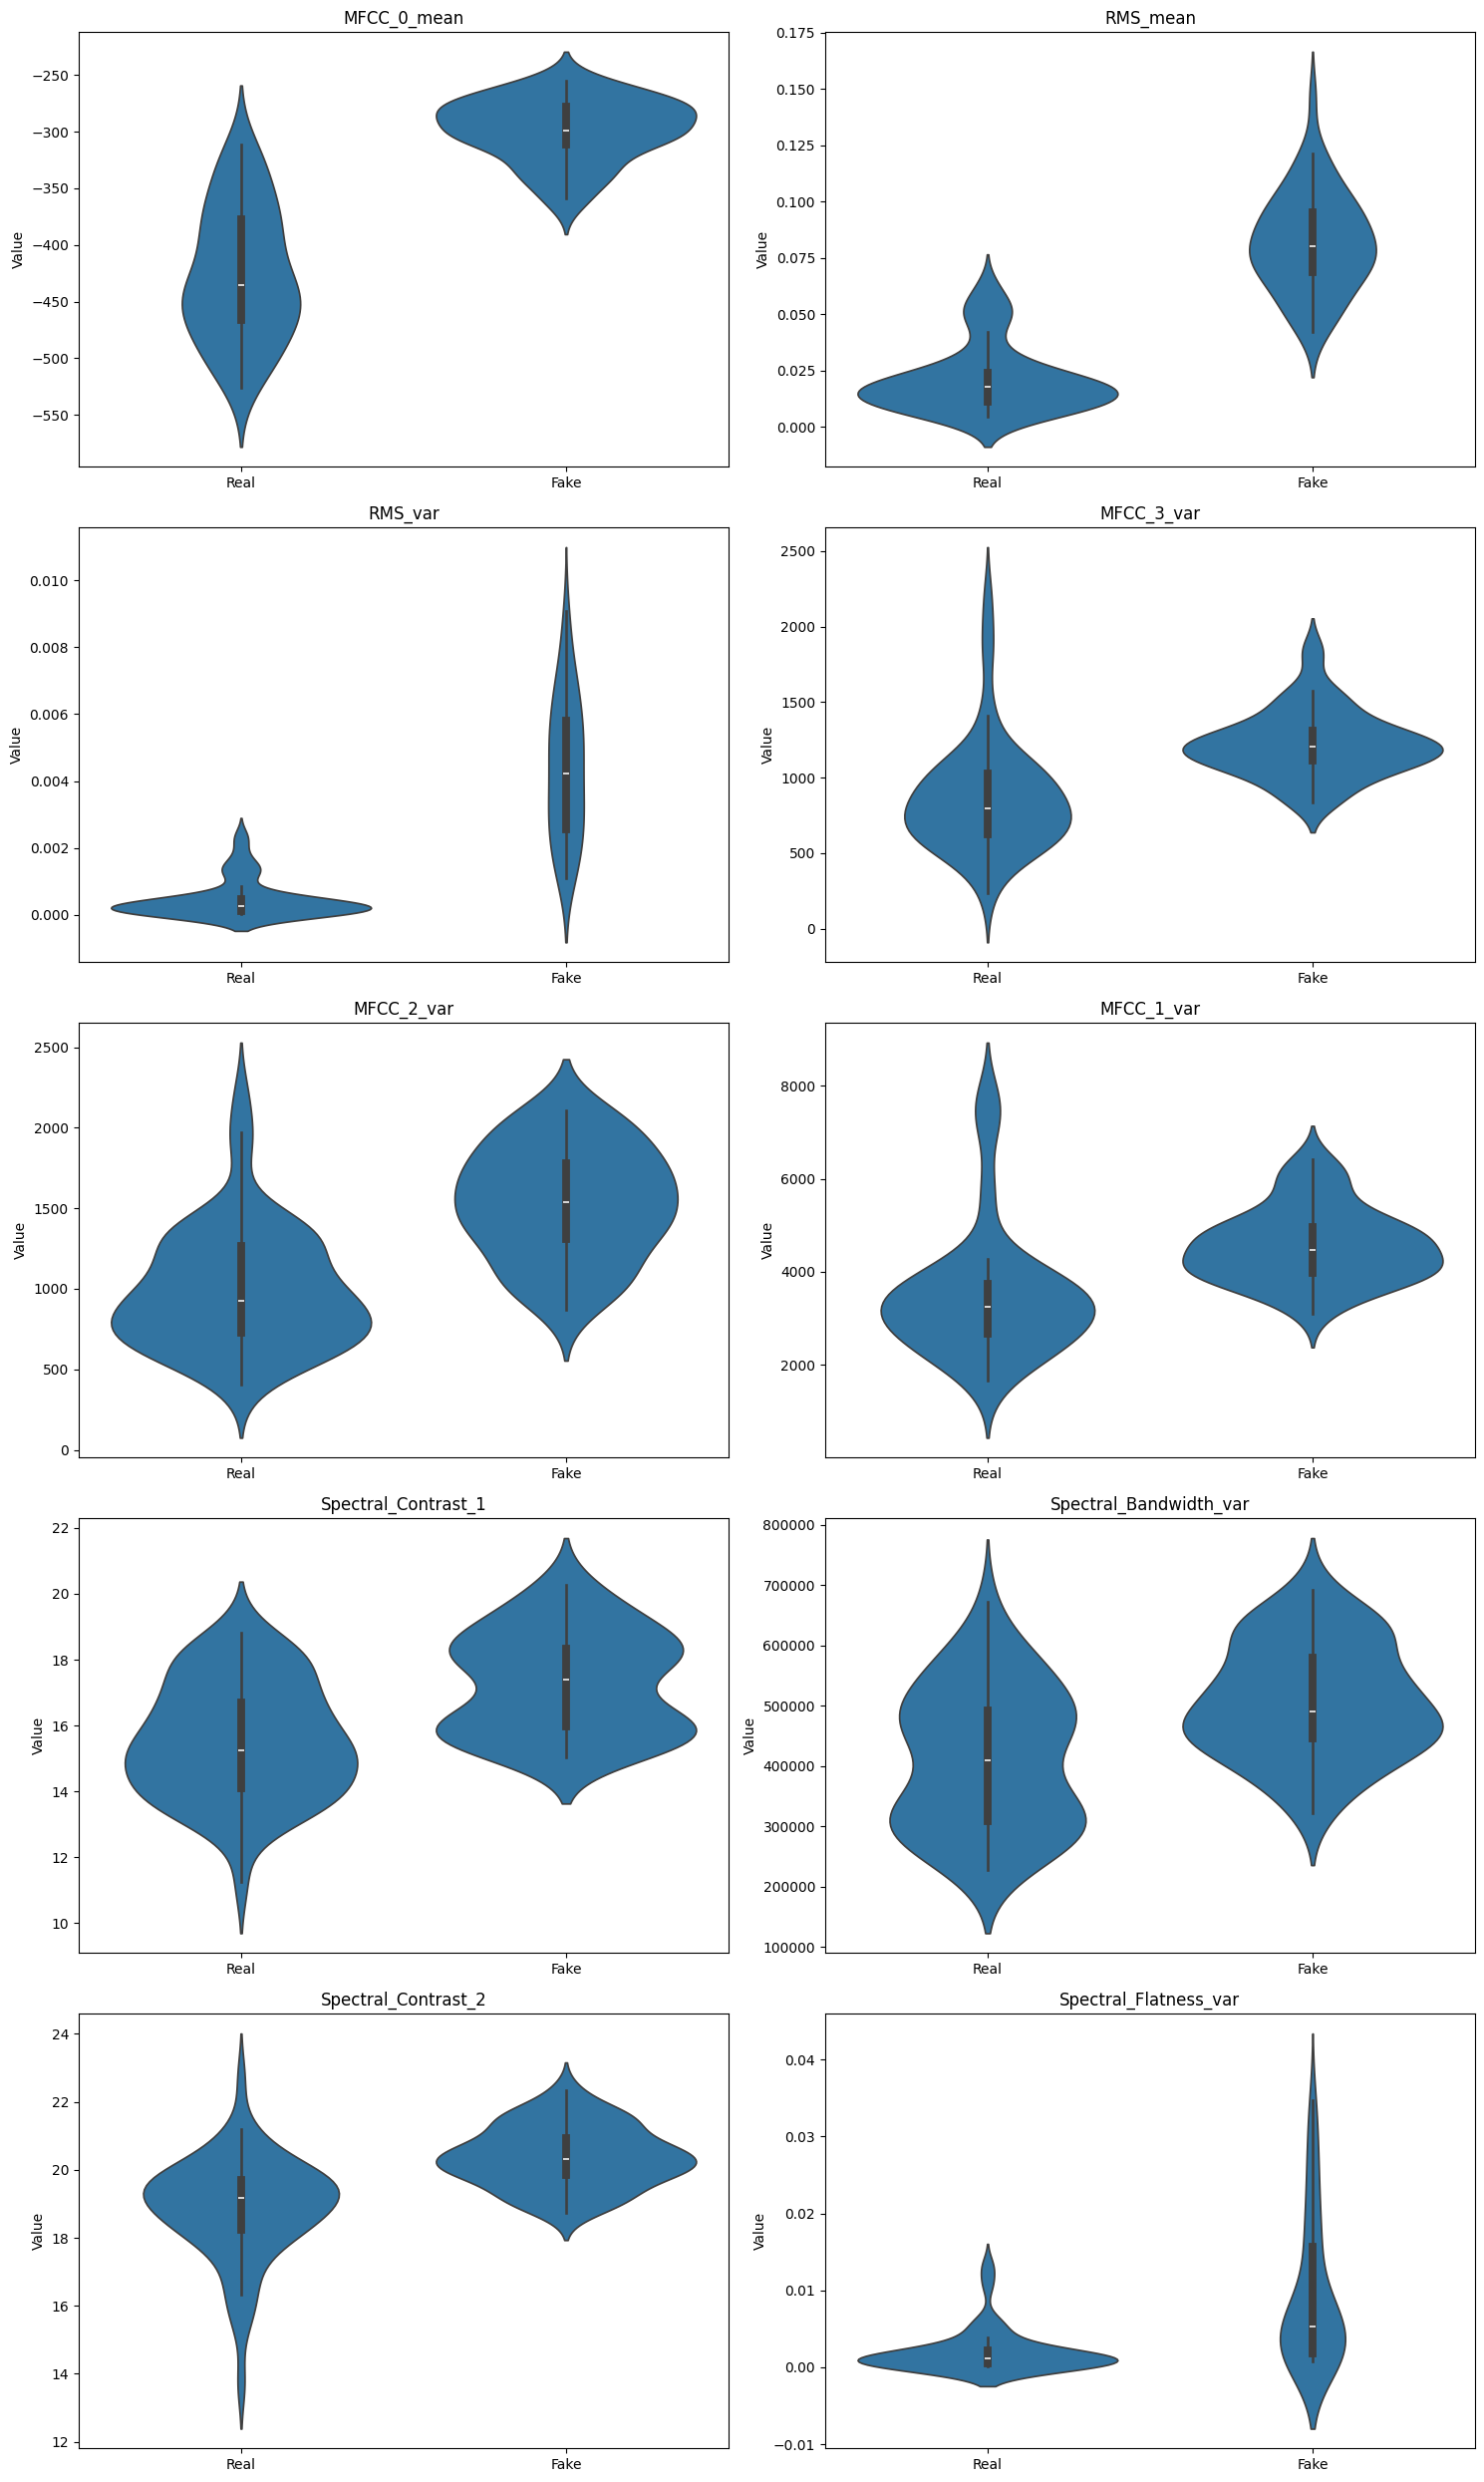


Plotting feature importance comparison...


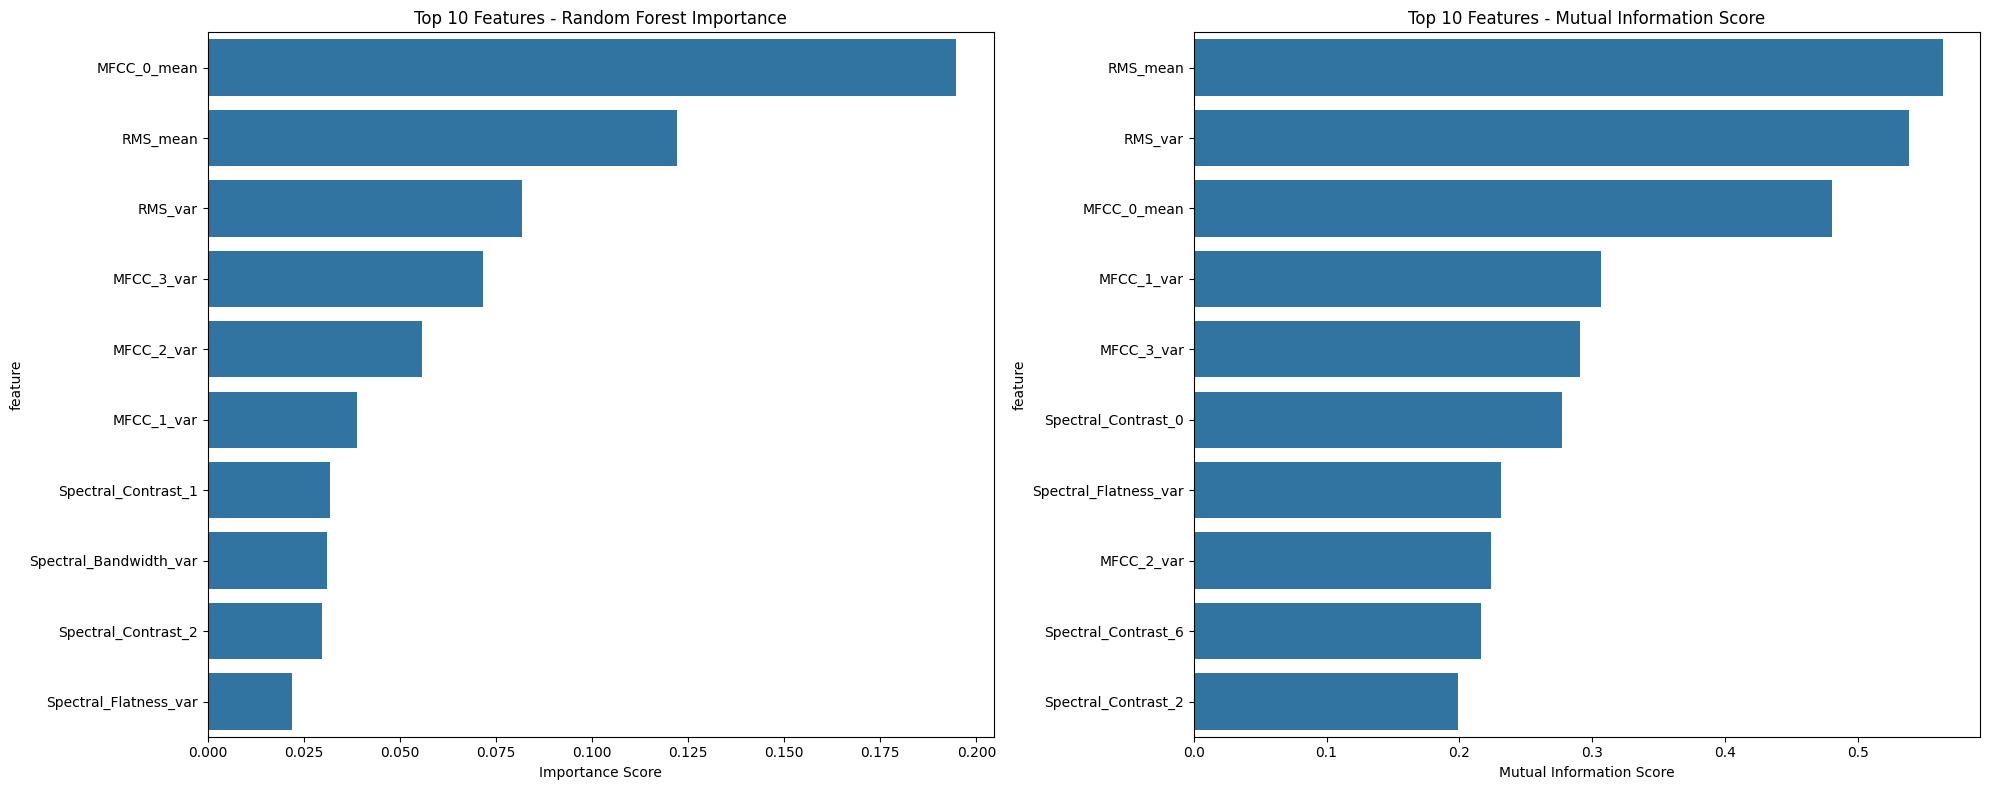


Calculating feature statistics...

Top 5 most significant features (based on t-test):
RMS_mean:
  t-statistic: -16.6967
  p-value: 0.0000

MFCC_0_mean:
  t-statistic: -14.1378
  p-value: 0.0000

RMS_var:
  t-statistic: -13.2966
  p-value: 0.0000

MFCC_2_var:
  t-statistic: -7.6607
  p-value: 0.0000

Spectral_Contrast_2:
  t-statistic: -6.1864
  p-value: 0.0000



In [33]:
# Run the analysis
if __name__ == "__main__":
    print("Running feature analysis...")

    # 1. Plot feature distributions
    print("\nPlotting feature distributions...")
    dist_fig = plot_feature_distributions(X, y, feature_names)
    plt.show()

    # 2. Plot feature importance comparison
    print("\nPlotting feature importance comparison...")
    importance_fig = plot_feature_importance_comparison(X, y, feature_names)
    plt.show()

    # 3. Calculate and display statistics
    print("\nCalculating feature statistics...")
    real_stats, fake_stats, t_test_results = analyze_feature_statistics(X, y, feature_names)

    # Display top 5 most significant features based on t-test
    print("\nTop 5 most significant features (based on t-test):")
    significant_features = sorted(
        t_test_results.items(),
        key=lambda x: abs(x[1]['t_statistic']),
        reverse=True
    )[:5]

    for feature, results in significant_features:
        print(f"{feature}:")
        print(f"  t-statistic: {results['t_statistic']:.4f}")
        print(f"  p-value: {results['p_value']:.4f}")
        print()